In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import torch

# --- Import chewc components ---
from chewc.population import quick_haplo, combine_populations, subset_population, msprime_pop
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.select import TruncationSelection

# --- Initial Setup ---
key = jax.random.PRNGKey(42)


In [ ]:
# --- Define Trait Architecture for Scenario A ---
print("Simulating Scenario A...")
key, trait_a_key, pheno_a_key = jax.random.split(key, 3)
sp_A = add_trait_a(
    key=trait_a_key,
    founder_pop=combined_pop, # Use the combined population
    sim_param=sp,
    n_qtl_per_chr=100,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=False
)

# --- Set Phenotypes for Scenario A ---
founder_pool_A = set_pheno(
    key=pheno_a_key,
    pop=combined_pop.replace(bv=None),
    traits=sp_A.traits,
    ploidy=sp_A.ploidy,
    h2=jnp.array([0.8])
)


In [ ]:
!pip install statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from statannotations.Annotator import Annotator # <-- NEW IMPORT
from scipy.stats import ttest_ind # <-- NEW IMPORT
import itertools # <-- NEW IMPORT


# --- Helper function for Confidence Ellipses (Unchanged) ---
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")
    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2, facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)
    transf = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# --- Pareto Plot of Terminal Outcomes (Unchanged) ---
def plot_pareto_front(df):
    terminal_df = df[df['generation'] == df['generation'].max()]
    fig, axes = plt.subplots(1, 3, figsize=(24, 7), sharey=True)
    fig.suptitle(f'Terminal Genetic Gain vs. Variance (Generation {df["generation"].max()})', fontsize=20, y=1.02)
    scenarios = sorted(terminal_df['scenario'].unique())
    for i, scenario in enumerate(scenarios):
        ax = axes[i]
        scenario_df = terminal_df[terminal_df['scenario'] == scenario]
        sns.scatterplot(data=scenario_df, x='var_bv', y='mean_bv', hue='strategy', style='strategy', s=150, ax=ax, legend=(i==len(scenarios)-1))
        for strategy in scenario_df['strategy'].unique():
            strategy_df = scenario_df[scenario_df['strategy'] == strategy]
            confidence_ellipse(strategy_df['var_bv'], strategy_df['mean_bv'], ax, edgecolor=sns.color_palette()[list(scenario_df['strategy'].unique()).index(strategy)], linewidth=2)
        ax.set_title(f'Scenario: {scenario}', fontsize=16)
        ax.set_xlabel(f'Terminal Genetic Variance ($V_{{A,{df["generation"].max()}}}$)', fontsize=12)
        ax.set_ylabel(f'Terminal Genetic Gain ($G_{{{df["generation"].max()}}}$)', fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
    plt.show()

# --- Trajectory Plots (Unchanged) ---
def plot_trajectories(df):
    fig, axes = plt.subplots(2, 3, figsize=(22, 12), sharex=True)
    fig.suptitle('Genetic Trajectories Over Generations (Mean of Replicates)', fontsize=20, y=1.0)
    scenarios = sorted(df['scenario'].unique())
    for i, scenario in enumerate(scenarios):
        scenario_df = df[df['scenario'] == scenario]
        sns.lineplot(data=scenario_df, x='generation', y='mean_bv', hue='strategy', ax=axes[0, i], linewidth=2.5, errorbar=None)
        axes[0, i].set_title(f'{scenario} - Genetic Gain', fontsize=16)
        axes[0, i].set_ylabel('Mean Breeding Value (Gain)')
        axes[0, i].grid(True, linestyle='--', alpha=0.6)
        axes[0, i].get_legend().remove()
        sns.lineplot(data=scenario_df, x='generation', y='var_bv', hue='strategy', ax=axes[1, i], linewidth=2.5, errorbar=None)
        axes[1, i].set_title(f'{scenario} - Genetic Variance', fontsize=16)
        axes[1, i].set_ylabel('Additive Genetic Variance ($V_A$)')
        axes[1, i].set_xlabel('Generation')
        axes[1, i].grid(True, linestyle='--', alpha=0.6)
        axes[1, i].get_legend().remove()
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', title='Strategy', bbox_to_anchor=(0.99, 0.95))
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])
    plt.show()


# --- Generational Boxplots (CORRECTED with Significance) ---
def plot_generational_boxplots(df):
    """
    Creates grouped boxplots with statistical annotations to show significant
    differences between strategies at key generations.
    """
    max_gen = df['generation'].max()
    plot_gens = [1, int(max_gen / 2), max_gen]
    gen_df = df[df['generation'].isin(plot_gens)]

    fig, axes = plt.subplots(2, 3, figsize=(22, 14))
    fig.suptitle('Distribution of Outcomes Across Replicates with Significance', fontsize=20, y=1.0)
    
    scenarios = sorted(gen_df['scenario'].unique())
    all_strategies = list(gen_df['strategy'].unique())
    
    for i, scenario in enumerate(scenarios):
        scenario_df = gen_df[gen_df['scenario'] == scenario]
        
        # --- CORRECTED: Build the pairs correctly for each plot ---
        # The annotator needs pairs of tuples: ((x_val, hue_val_1), (x_val, hue_val_2))
        comparison_pairs = []
        for gen in plot_gens:
            # Create pairs for this specific generation
            pairs_for_gen = [
                ((gen, 'Truncation'), (gen, s))
                for s in all_strategies if s != 'Truncation'
            ]
            comparison_pairs.extend(pairs_for_gen)
            
        # --- Boxplot for Mean BV with annotations ---
        ax_gain = axes[0, i]
        # Draw the boxplot first
        sns.boxplot(data=scenario_df, x='generation', y='mean_bv', hue='strategy', ax=ax_gain)
        
        # Then, create and apply the annotator
        annotator_gain = Annotator(ax_gain, comparison_pairs, data=scenario_df, x='generation', y='mean_bv', hue='strategy')
        annotator_gain.configure(test='t-test_ind', text_format='star', loc='inside', verbose=False)
        annotator_gain.apply_and_annotate()
        
        ax_gain.set_title(f'{scenario} - Genetic Gain', fontsize=16)
        ax_gain.set_ylabel('Mean Breeding Value (Gain)')
        if i > 0: ax_gain.get_legend().remove()

        # --- Boxplot for Var BV with annotations ---
        ax_var = axes[1, i]
        # Draw the boxplot first
        sns.boxplot(data=scenario_df, x='generation', y='var_bv', hue='strategy', ax=ax_var)
        
        # Then, create and apply the annotator
        annotator_var = Annotator(ax_var, comparison_pairs, data=scenario_df, x='generation', y='var_bv', hue='strategy')
        annotator_var.configure(test='t-test_ind', text_format='star', loc='inside', verbose=False)
        annotator_var.apply_and_annotate()

        ax_var.set_title(f'{scenario} - Genetic Variance', fontsize=16)
        ax_var.set_ylabel('Additive Genetic Variance ($V_A$)')
        ax_var.set_xlabel('Generation')
        ax_var.get_legend().remove()

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# --- QTL Allele Frequency Plots (Unchanged) ---
def plot_qtl_frequencies(df):
    if 'qtl_freqs' not in df.columns or df['qtl_freqs'].apply(lambda x: x is None or (isinstance(x, float) and np.isnan(x))).all():
        print("\nQTL frequency data not found in results. Skipping this plot.")
        return
    qtl_df_list = []
    for _, row in df.iterrows():
        freqs = row['qtl_freqs']
        if isinstance(freqs, (list, np.ndarray)):
            for i, freq in enumerate(freqs):
                new_row = row.to_dict()
                new_row['qtl_index'] = f"QTL_{i+1}"
                new_row['frequency'] = freq
                qtl_df_list.append(new_row)
    qtl_df = pd.DataFrame(qtl_df_list)
    oligogenic_df = qtl_df[qtl_df['scenario'] == 'Scenario C (Oligogenic)']
    if oligogenic_df.empty:
        print("\nNo data for 'Scenario C (Oligogenic)'. Skipping QTL plot.")
        return
    g = sns.FacetGrid(oligogenic_df, col="strategy", col_wrap=3, height=5, aspect=1.2)
    g.map(sns.lineplot, "generation", "frequency", "qtl_index", alpha=0.8, errorbar=None)
    g.add_legend(title="Top 10 QTLs")
    g.fig.suptitle('QTL Allele Frequencies Over Time (Scenario C: Oligogenic)', fontsize=20, y=1.03)
    g.set_axis_labels("Generation", "Allele Frequency")
    g.set_titles("Strategy: {col_name}", size=14)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- Main Analysis Execution ---
df_results = pd.DataFrame(all_results)
# print("--- Starting Analysis & Visualization ---")
df_results.sort_values(by=['scenario', 'strategy', 'replicate', 'generation'], inplace=True)
#
plot_trajectories(df_results)
plot_generational_boxplots(df_results) # <-- This will now have asterisks
plot_pareto_front(df_results)
plot_qtl_frequencies(df_results)
#
# print("\n--- Analysis Complete ---")

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import torch
import random
import optuna # Import the hyperparameter optimization library

# --- Import custom simulation library components ---
from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.select import TruncationSelection

# --- Import Bayesian Optimization components ---
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.objective import IdentityMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

# ==============================================================================
# --- 1. CORE SIMULATION FUNCTIONS ---
# These functions will be called by the Optuna objective function
# ==============================================================================

def run_breeding_program(key, initial_pop, sp, n_generations, n_parents, n_progeny, h2_val):
    """Simulates a breeding program from a set of founders."""
    current_pop = initial_pop
    history = []
    for gen in range(n_generations + 1):
        history.append({'gen': gen, 'mean_bv': current_pop.bv.mean()})
        if gen == n_generations:
            break

        parent_indices = jnp.argsort(current_pop.bv[:, 0])[-n_parents:]
        key, cross_key_m, cross_key_f, pheno_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(cross_key_m, parent_indices, shape=(n_progeny,))
        father_iids = jax.random.choice(cross_key_f, parent_indices, shape=(n_progeny,))
        cross_plan = jnp.stack([mother_iids, father_iids], axis=1)

        next_id = jnp.max(current_pop.id) + 1
        progeny_pop = make_cross(key, current_pop, cross_plan, sp, next_id)
        progeny_pop = set_pheno(pheno_key, progeny_pop, sp.traits, sp.ploidy, h2=jnp.array([h2_val]))
        current_pop = progeny_pop
    return history

def run_single_strategy(strategy_name, selector_func, key, base_founder_pool, sp, params):
    """Runs a complete simulation for a single strategy and returns the terminal BV."""
    print(f"    - Testing Strategy: {strategy_name}")
    key, sel_key, sim_key = jax.random.split(key)

    if strategy_name == 'Truncation':
        indices = selector_func.select_parents(sel_key, base_founder_pool, sp, params['N_SELECT_FOUNDERS'])
    else: # Bayesian Optimization
        indices = selector_func(base_founder_pool, sp, params)

    initial_founders = subset_population(base_founder_pool, indices)
    history = run_breeding_program(
        sim_key, initial_founders, sp,
        params['N_GENERATIONS'], params['N_PARENTS_PER_GEN'], params['N_PROGENY_PER_GEN'], params['TRAIT_H2']
    )
    return float(history[-1]['mean_bv'])

# ==============================================================================
# --- 2. OPTUNA OBJECTIVE FUNCTION ---
# This is the core of the hyperparameter search.
# ==============================================================================

def objective(trial):
    """
    Optuna objective function to find parameters that maximize the difference
    between BO-CR and Truncation selection.
    """
    # --- Suggest Hyperparameters ---
    params = {
        'N_GENERATIONS': trial.suggest_int('N_GENERATIONS', 10, 30),
        'N_SELECT_FOUNDERS': trial.suggest_int('N_SELECT_FOUNDERS', 5, 50),
        'N_PARENTS_PER_GEN': trial.suggest_int('N_PARENTS_PER_GEN', 5, 50),
        'N_PROGENY_PER_GEN': trial.suggest_int('N_PROGENY_PER_GEN', 50, 300),
        'N_QTL_PER_CHR': trial.suggest_int('N_QTL_PER_CHR', 10, 200),
        'TRAIT_H2': trial.suggest_float('TRAIT_H2', 0.1, 0.7),
        'GAMMA_SHAPE': trial.suggest_float('GAMMA_SHAPE', 0.2, 1.0),
        'N_REPLICATES': 2 # Use a small number of replicates for speed during optimization
    }
    
    # --- Setup simulation environment with suggested params ---
    key = jax.random.PRNGKey(trial.number) # Use trial number for seed
    key, pop_key, trait_key, pheno_key = jax.random.split(key, 4)

    # For this search, we will use a non-structured founder pool as in the original code.
    # A structured pool could also be used but would make the search much longer.
    founder_pool, gen_map = quick_haplo(
        key=pop_key, n_ind=300, n_chr=5, n_loci_per_chr=500
    )
    sp = SimParam.from_founder_pop(founder_pool, gen_map)

    sp_scenario = add_trait_a(
        key=trait_key, founder_pop=founder_pool, sim_param=sp,
        n_qtl_per_chr=params['N_QTL_PER_CHR'],
        mean=jnp.array([0.0]), var=jnp.array([1.0]),
        gamma=True, shape=params['GAMMA_SHAPE']
    )
    founder_pool_pheno = set_pheno(
        key=pheno_key, pop=founder_pool, traits=sp_scenario.traits,
        ploidy=sp_scenario.ploidy, h2=jnp.array([params['TRAIT_H2']])
    )
    
    # --- BO-CR specific functions (need to be defined here to access params) ---
    def evaluate_objective_bo(x, base_founder_pool, sp):
        x_cpu = x.squeeze(0).cpu().numpy()
        founder_indices = jnp.argsort(x_cpu)[-params['N_SELECT_FOUNDERS']:]
        initial_founders = subset_population(base_founder_pool, founder_indices)
        sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
        history = run_breeding_program(
            sim_key, initial_founders, sp, params['N_GENERATIONS'],
            params['N_PARENTS_PER_GEN'], params['N_PROGENY_PER_GEN'], params['TRAIT_H2']
        )
        return torch.tensor([[history[-1]['mean_bv'], 0.0]], dtype=torch.double) # Note: variance is ignored for this objective

    def botorch_cr_selector_bo(pool, sp, params_dict):
        bounds = torch.tensor([[0.0] * pool.nInd, [1.0] * pool.nInd], dtype=torch.double)
        train_x = torch.rand(10, pool.nInd, dtype=torch.double)
        train_obj = torch.cat([evaluate_objective_bo(x.unsqueeze(0), pool, sp) for x in train_x], dim=0)
        # Simplified BO loop for speed
        for _ in range(10): # A very short search for the hyperparameter tuning
             model = SingleTaskGP(train_x, train_obj[:, 0:1])
             mll = ExactMarginalLogLikelihood(model.likelihood, model)
             fit_gpytorch_mll(mll)
             # Using a simple UCB acquisition function for single objective
             from botorch.acquisition import UpperConfidenceBound
             acqf = UpperConfidenceBound(model, beta=0.1)
             candidates, _ = optimize_acqf(acq_function=acqf, bounds=bounds, q=1, num_restarts=5, raw_samples=256)
             new_x = candidates.detach()
             new_obj = evaluate_objective_bo(new_x, pool, sp)
             train_x = torch.cat([train_x, new_x], dim=0)
             train_obj = torch.cat([train_obj, new_obj], dim=0)
        best_idx = train_obj[:, 0].argmax()
        best_x = train_x[best_idx].cpu().numpy()
        return jnp.argsort(best_x)[-params_dict['N_SELECT_FOUNDERS']:]


    # --- Run experiment for both strategies ---
    terminal_gains = {'Truncation': [], 'BO-CR': []}
    for rep in range(params['N_REPLICATES']):
        key, rep_key = jax.random.split(key)
        
        # Run Truncation
        gain_trunc = run_single_strategy(
            'Truncation', TruncationSelection(), rep_key, founder_pool_pheno, sp_scenario, params
        )
        terminal_gains['Truncation'].append(gain_trunc)
        
        # Run BO-CR
        gain_bocr = run_single_strategy(
            'BO-CR', botorch_cr_selector_bo, rep_key, founder_pool_pheno, sp_scenario, params
        )
        terminal_gains['BO-CR'].append(gain_bocr)

    # --- Calculate and return the objective value ---
    mean_gain_trunc = np.mean(terminal_gains['Truncation'])
    mean_gain_bocr = np.mean(terminal_gains['BO-CR'])
    
    difference = mean_gain_bocr - mean_gain_trunc
    print(f"  > Trial Complete. Difference = {difference:.4f}")
    
    return difference

# ==============================================================================
# --- 3. RUN OPTUNA STUDY ---
# ==============================================================================
print("--- Starting Hyperparameter Optimization with Optuna ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials to search for the best parameters

print("\n--- Optimization Finished ---")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# --- Visualize the results ---
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import torch
import random
import optuna # Import the hyperparameter optimization library

# --- Import custom simulation library components ---
from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.select import TruncationSelection

# --- Import Bayesian Optimization components ---
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.objective import IdentityMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

# ==============================================================================
# --- 1. CORE SIMULATION FUNCTIONS ---
# These functions will be called by the Optuna objective function
# ==============================================================================

def run_breeding_program(key, initial_pop, sp, n_generations, n_parents, n_progeny, h2_val):
    """Simulates a breeding program from a set of founders."""
    current_pop = initial_pop
    history = []
    for gen in range(n_generations + 1):
        history.append({'gen': gen, 'mean_bv': current_pop.bv.mean()})
        if gen == n_generations:
            break

        parent_indices = jnp.argsort(current_pop.bv[:, 0])[-n_parents:]
        key, cross_key_m, cross_key_f, pheno_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(cross_key_m, parent_indices, shape=(n_progeny,))
        father_iids = jax.random.choice(cross_key_f, parent_indices, shape=(n_progeny,))
        cross_plan = jnp.stack([mother_iids, father_iids], axis=1)

        next_id = jnp.max(current_pop.id) + 1
        progeny_pop = make_cross(key, current_pop, cross_plan, sp, next_id)
        progeny_pop = set_pheno(pheno_key, progeny_pop, sp.traits, sp.ploidy, h2=jnp.array([h2_val]))
        current_pop = progeny_pop
    return history

def run_single_strategy(strategy_name, selector_func, key, base_founder_pool, sp, params):
    """Runs a complete simulation for a single strategy and returns the terminal BV."""
    print(f"    - Testing Strategy: {strategy_name}")
    
    # --- FIX IS HERE ---
    # We need to explicitly ask for 3 new keys.
    key, sel_key, sim_key = jax.random.split(key, 3)

    if strategy_name == 'Truncation':
        indices = selector_func.select_parents(sel_key, base_founder_pool, sp, params['N_SELECT_FOUNDERS'])
    else: # Bayesian Optimization
        indices = selector_func(base_founder_pool, sp, params)

    initial_founders = subset_population(base_founder_pool, indices)
    history = run_breeding_program(
        sim_key, initial_founders, sp,
        params['N_GENERATIONS'], params['N_PARENTS_PER_GEN'], params['N_PROGENY_PER_GEN'], params['TRAIT_H2']
    )
    return float(history[-1]['mean_bv'])

# ==============================================================================
# --- 2. OPTUNA OBJECTIVE FUNCTION ---
# This is the core of the hyperparameter search.
# ==============================================================================

def objective(trial):
    """
    Optuna objective function to find parameters that maximize the difference
    between BO-CR and Truncation selection.
    """
    # --- Suggest Hyperparameters ---
    params = {
        'N_GENERATIONS': trial.suggest_int('N_GENERATIONS', 10, 30),
        'N_SELECT_FOUNDERS': trial.suggest_int('N_SELECT_FOUNDERS', 5, 50),
        'N_PARENTS_PER_GEN': trial.suggest_int('N_PARENTS_PER_GEN', 5, 50),
        'N_PROGENY_PER_GEN': trial.suggest_int('N_PROGENY_PER_GEN', 50, 300),
        'N_QTL_PER_CHR': trial.suggest_int('N_QTL_PER_CHR', 10, 200),
        'TRAIT_H2': trial.suggest_float('TRAIT_H2', 0.1, 0.7),
        'GAMMA_SHAPE': trial.suggest_float('GAMMA_SHAPE', 0.2, 1.0),
        'N_REPLICATES': 2 # Use a small number of replicates for speed during optimization
    }
    
    # --- Setup simulation environment with suggested params ---
    key = jax.random.PRNGKey(trial.number) # Use trial number for seed
    key, pop_key, trait_key, pheno_key = jax.random.split(key, 4)

    # For this search, we will use a non-structured founder pool as in the original code.
    # A structured pool could also be used but would make the search much longer.
    founder_pool, gen_map = quick_haplo(
        key=pop_key, n_ind=300, n_chr=5, n_loci_per_chr=500
    )
    sp = SimParam.from_founder_pop(founder_pool, gen_map)

    sp_scenario = add_trait_a(
        key=trait_key, founder_pop=founder_pool, sim_param=sp,
        n_qtl_per_chr=params['N_QTL_PER_CHR'],
        mean=jnp.array([0.0]), var=jnp.array([1.0]),
        gamma=True, shape=params['GAMMA_SHAPE']
    )
    founder_pool_pheno = set_pheno(
        key=pheno_key, pop=founder_pool, traits=sp_scenario.traits,
        ploidy=sp_scenario.ploidy, h2=jnp.array([params['TRAIT_H2']])
    )
    
    # --- BO-CR specific functions (need to be defined here to access params) ---
    def evaluate_objective_bo(x, base_founder_pool, sp):
        x_cpu = x.squeeze(0).cpu().numpy()
        founder_indices = jnp.argsort(x_cpu)[-params['N_SELECT_FOUNDERS']:]
        initial_founders = subset_population(base_founder_pool, founder_indices)
        sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
        history = run_breeding_program(
            sim_key, initial_founders, sp, params['N_GENERATIONS'],
            params['N_PARENTS_PER_GEN'], params['N_PROGENY_PER_GEN'], params['TRAIT_H2']
        )
        
        # --- FIX IS HERE ---
        # Convert the JAX array to a standard Python float before creating the tensor.
        terminal_gain = float(history[-1]['mean_bv'])
        
        # Note: variance is ignored for this objective, so we pass 0.0
        return torch.tensor([[terminal_gain, 0.0]], dtype=torch.double) 

    def botorch_cr_selector_bo(pool, sp, params_dict):
        bounds = torch.tensor([[0.0] * pool.nInd, [1.0] * pool.nInd], dtype=torch.double)
        train_x = torch.rand(10, pool.nInd, dtype=torch.double)
        train_obj = torch.cat([evaluate_objective_bo(x.unsqueeze(0), pool, sp) for x in train_x], dim=0)
        # Simplified BO loop for speed
        for _ in range(10): # A very short search for the hyperparameter tuning
             model = SingleTaskGP(train_x, train_obj[:, 0:1])
             mll = ExactMarginalLogLikelihood(model.likelihood, model)
             fit_gpytorch_mll(mll)
             # Using a simple UCB acquisition function for single objective
             from botorch.acquisition import UpperConfidenceBound
             acqf = UpperConfidenceBound(model, beta=0.1)
             candidates, _ = optimize_acqf(acq_function=acqf, bounds=bounds, q=1, num_restarts=5, raw_samples=256)
             new_x = candidates.detach()
             new_obj = evaluate_objective_bo(new_x, pool, sp)
             train_x = torch.cat([train_x, new_x], dim=0)
             train_obj = torch.cat([train_obj, new_obj], dim=0)
        best_idx = train_obj[:, 0].argmax()
        best_x = train_x[best_idx].cpu().numpy()
        return jnp.argsort(best_x)[-params_dict['N_SELECT_FOUNDERS']:]


    # --- Run experiment for both strategies ---
    terminal_gains = {'Truncation': [], 'BO-CR': []}
    for rep in range(params['N_REPLICATES']):
        key, rep_key = jax.random.split(key)
        
        # Run Truncation
        gain_trunc = run_single_strategy(
            'Truncation', TruncationSelection(), rep_key, founder_pool_pheno, sp_scenario, params
        )
        terminal_gains['Truncation'].append(gain_trunc)
        
        # Run BO-CR
        gain_bocr = run_single_strategy(
            'BO-CR', botorch_cr_selector_bo, rep_key, founder_pool_pheno, sp_scenario, params
        )
        terminal_gains['BO-CR'].append(gain_bocr)

    # --- Calculate and return the objective value ---
    mean_gain_trunc = np.mean(terminal_gains['Truncation'])
    mean_gain_bocr = np.mean(terminal_gains['BO-CR'])
    
    difference = mean_gain_bocr - mean_gain_trunc
    print(f"  > Trial Complete. Difference = {difference:.4f}")
    
    return difference

# ==============================================================================
# --- 3. RUN OPTUNA STUDY ---
# ==============================================================================
print("--- Starting Hyperparameter Optimization with Optuna ---")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50) # Run 50 trials to search for the best parameters

print("\n--- Optimization Finished ---")
print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# --- Visualize the results ---
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
import seaborn as sns

# --- Import custom simulation library components ---
from chewc.population import msprime_pop, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.select import TruncationSelection

# --- Import Bayesian Optimization components ---
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
# --- FIX: Correct the import path for the acquisition function ---
from botorch.acquisition.multi_objective import qLogExpectedHypervolumeImprovement
from botorch.acquisition.multi_objective.objective import IdentityMCMultiOutputObjective
from botorch.optim import optimize_acqf
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.sampling.normal import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

# ==============================================================================
# --- FINAL EXPERIMENT CONFIGURATION (FROM OPTUNA RESULTS) ---
# ==============================================================================

# --- Optimal Parameters from Trial 23 ---
P = {
    'N_GENERATIONS': 29,
    'N_SELECT_FOUNDERS': 31,
    'N_PARENTS_PER_GEN': 8,
    'N_PROGENY_PER_GEN': 259,
    'N_QTL_PER_CHR': 170,
    'TRAIT_H2': 0.6416,
    'GAMMA_SHAPE': 0.3920
}

# --- General Simulation Settings ---
N_REPLICATES = 20           # A robust number for final analysis
N_SUBPOPULATIONS = 2        # A structured population for a challenging scenario
N_FOUNDERS_PER_SUBPOP = 150 # Total pool of 300 individuals
N_LOCI_PER_CHR = 500
N_CHR = 5

# --- Optimizer Settings ---
EVALUATION_BUDGET = 200      # The optimizer's "thinking time"
N_INITIAL_SAMPLES = 20
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.double
MAIN_KEY = jax.random.PRNGKey(123)

# ==============================================================================
# --- 1. SETUP FOUNDER POPULATION & TRAIT ---
# ==============================================================================
print("--- Stage 1: Setting up Founder Population & Trait ---")
key, pop_key, trait_key, pheno_key = jax.random.split(MAIN_KEY, 4)

# Create a structured founder pool
sub_populations = []
gen_map = None
for i in range(N_SUBPOPULATIONS):
    key, sub_pop_key = jax.random.split(key)
    pop, map_data = msprime_pop(key=sub_pop_key, n_ind=N_FOUNDERS_PER_SUBPOP, n_loci_per_chr=N_LOCI_PER_CHR, n_chr=N_CHR, effective_population_size=50)
    sub_populations.append(pop)
    if i == 0: gen_map = map_data

founder_pool = sub_populations[0]
for i in range(1, N_SUBPOPULATIONS):
    founder_pool = combine_populations(founder_pool, sub_populations[i])
N_FOUNDERS_TOTAL = founder_pool.nInd

# Create simulation parameters and trait architecture
sp = SimParam.from_founder_pop(founder_pool, gen_map)
sp_scenario = add_trait_a(
    key=trait_key, founder_pop=founder_pool, sim_param=sp,
    n_qtl_per_chr=P['N_QTL_PER_CHR'],
    mean=jnp.array([0.0]), var=jnp.array([1.0]),
    gamma=True, shape=P['GAMMA_SHAPE']
)
founder_pool_pheno = set_pheno(
    key=pheno_key, pop=founder_pool, traits=sp_scenario.traits,
    ploidy=sp_scenario.ploidy, h2=jnp.array([P['TRAIT_H2']])
)
# --- FIX: Prevent FrozenInstanceError by creating a new object with .replace() ---
# This creates a new population object with the modified 'bv' attribute.
founder_pool_pheno = founder_pool_pheno.replace(bv=jnp.nan_to_num(founder_pool_pheno.bv, nan=-jnp.inf))

print(f"--- Setup Complete: {N_FOUNDERS_TOTAL} founders ready for simulation. ---\n")

# ==============================================================================
# --- 2. CORE SIMULATION & OPTIMIZER FUNCTIONS ---
# ==============================================================================

def run_breeding_program(key, initial_pop, sp):
    """Simulates a breeding program using parameters from dict `P`."""
    current_pop = initial_pop
    history = []
    for gen in range(P['N_GENERATIONS'] + 1):
        history.append({
            'gen': gen,
            'mean_bv': current_pop.bv.mean(),
            'var_bv': current_pop.bv.var()
        })
        if gen == P['N_GENERATIONS']: break
        parent_indices = jnp.argsort(current_pop.bv[:, 0])[-P['N_PARENTS_PER_GEN']:]
        key, cross_key_m, cross_key_f, pheno_key = jax.random.split(key, 4)
        mother_iids = jax.random.choice(cross_key_m, parent_indices, shape=(P['N_PROGENY_PER_GEN'],))
        father_iids = jax.random.choice(cross_key_f, parent_indices, shape=(P['N_PROGENY_PER_GEN'],))
        cross_plan = jnp.stack([mother_iids, father_iids], axis=1)
        next_id = jnp.max(current_pop.id) + 1
        progeny_pop = make_cross(key, current_pop, cross_plan, sp, next_id)
        progeny_pop = set_pheno(pheno_key, progeny_pop, sp.traits, sp.ploidy, h2=jnp.array([P['TRAIT_H2']]))
        # --- FIX: Prevent FrozenInstanceError by creating a new object with .replace() ---
        progeny_pop = progeny_pop.replace(bv=jnp.nan_to_num(progeny_pop.bv, nan=-jnp.inf))
        current_pop = progeny_pop
    return history

def evaluate_objective_multiobjective(x, base_founder_pool, sp):
    """BoTorch objective for MULTI-OBJECTIVE optimization (gain AND variance)."""
    founder_indices = jnp.argsort(x.squeeze(0).cpu().numpy())[-P['N_SELECT_FOUNDERS']:]
    initial_founders = subset_population(base_founder_pool, founder_indices)
    sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
    history = run_breeding_program(sim_key, initial_founders, sp)
    terminal_gain = float(history[-1]['mean_bv'])
    terminal_variance = float(history[-1]['var_bv'])
    return torch.tensor([[terminal_gain, terminal_variance]], dtype=DTYPE, device=DEVICE)

def botorch_cr_selector_multiobjective(pool, sp):
    """Multi-objective BO selector."""
    bounds = torch.tensor([[0.0] * N_FOUNDERS_TOTAL, [1.0] * N_FOUNDERS_TOTAL], device=DEVICE, dtype=DTYPE)
    train_x = torch.rand(N_INITIAL_SAMPLES, N_FOUNDERS_TOTAL, device=DEVICE, dtype=DTYPE)

    # --- Evaluate initial random points with a progress indicator ---
    # This initial step can be time-consuming, so feedback is helpful.
    print(f"      > Evaluating {N_INITIAL_SAMPLES} initial random points...")
    initial_objs = []
    for i, x in enumerate(train_x):
        print(f"        - Initial Point {i+1}/{N_INITIAL_SAMPLES}", end='\r')
        initial_objs.append(evaluate_objective_multiobjective(x.unsqueeze(0), pool, sp))
    print("\n      > Initial evaluation complete. Starting BO loop.")
    train_obj = torch.cat(initial_objs, dim=0)


    for i in range(N_INITIAL_SAMPLES, EVALUATION_BUDGET):
        print(f"      > BO Iteration {i+1}/{EVALUATION_BUDGET}", end='\r')
        # The InputDataWarning may still appear if initial samples have zero variance,
        # but the + 1e-6 prevents crashes and the model can still proceed.
        standardized_obj = (train_obj - train_obj.mean(dim=0)) / (train_obj.std(dim=0) + 1e-6)
        model = SingleTaskGP(train_x, standardized_obj)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        ref_point = train_obj.min(dim=0).values - 0.1
        
        acq_func = qLogExpectedHypervolumeImprovement(
            model=model, ref_point=ref_point,
            partitioning=FastNondominatedPartitioning(ref_point=ref_point, Y=standardized_obj),
            sampler=SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCMultiOutputObjective(outcomes=[0, 1])
        )
        
        # --- FIX: Restore the optimization option from the faster legacy code ---
        # This significantly speeds up the "thinking time" of the optimizer at each step.
        candidates, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,
            num_restarts=10,
            raw_samples=512,
            options={"sample_around_best": True}
        )
        new_x = candidates.detach()
        new_obj = evaluate_objective_multiobjective(new_x, pool, sp)
        train_x = torch.cat([train_x, new_x], dim=0)
        train_obj = torch.cat([train_obj, new_obj], dim=0)
    
    print("\n      > BO search complete. Selecting best founder set.")
    pareto_mask = is_non_dominated(train_obj)
    scaled_pareto_y = (train_obj[pareto_mask] - train_obj.mean(dim=0)) / (train_obj.std(dim=0) + 1e-6)
    best_idx = scaled_pareto_y.sum(dim=1).argmax()
    best_x = train_x[pareto_mask][best_idx].cpu().numpy()
    return jnp.argsort(best_x)[-P['N_SELECT_FOUNDERS']:]


# ==============================================================================
# --- 3. MAIN EXPERIMENT LOOP ---
# ==============================================================================
print("\n--- Stage 2: Running Final Experiment ---")

strategies_to_run = {
    'Truncation': TruncationSelection(),
    'BO-CR-Prescient': botorch_cr_selector_multiobjective
}

all_results = []
for rep in range(N_REPLICATES):
    print(f"  --- Running Replicate {rep+1}/{N_REPLICATES} ---")
    for strategy_name, selector in strategies_to_run.items():
        print(f"    - Strategy: {strategy_name}")
        key, sel_key, sim_key = jax.random.split(key, 3)

        if strategy_name == 'Truncation':
            indices = selector.select_parents(sel_key, founder_pool_pheno, sp_scenario, P['N_SELECT_FOUNDERS'])
        else: # Bayesian Optimization
            indices = selector(founder_pool_pheno, sp_scenario)
        
        initial_founders = subset_population(founder_pool_pheno, indices)
        # The history now contains data for ALL generations
        history = run_breeding_program(sim_key, initial_founders, sp_scenario)

        # Store the full history for this run
        for gen_data in history:
            all_results.append({
                'replicate': rep,
                'strategy': strategy_name,
                'generation': gen_data['gen'],
                'mean_bv': float(gen_data['mean_bv']),
                'var_bv': float(gen_data['var_bv'])
            })

df_results = pd.DataFrame(all_results)
print("\n--- Experiment Complete ---")

# ==============================================================================
# --- 4. VISUALIZATION ---
# ==============================================================================
print("\n--- Stage 3: Generating Final Plots ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Plot Mean Genetic Value (Gain)
sns.lineplot(data=df_results, x='generation', y='mean_bv', hue='strategy', ax=ax1, errorbar='sd', linewidth=3)
ax1.set_title('Genetic Gain Over Time', fontsize=18, fontweight='bold')
ax1.set_xlabel('Generation', fontsize=14)
ax1.set_ylabel('Mean Breeding Value', fontsize=14)
ax1.legend(title='Strategy', fontsize=12)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plot Genetic Variance
sns.lineplot(data=df_results, x='generation', y='var_bv', hue='strategy', ax=ax2, errorbar='sd', linewidth=3)
ax2.set_title('Genetic Variance Over Time', fontsize=18, fontweight='bold')
ax2.set_xlabel('Generation', fontsize=14)
ax2.set_ylabel('Additive Genetic Variance', fontsize=14)
ax2.legend(title='Strategy', fontsize=12)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.suptitle('Definitive Comparison of Founder Selection Strategies', fontsize=22, fontweight='bold', y=1.03)
plt.tight_layout()
plt.show()



--- Stage 1: Setting up Founder Population & Trait ---
--- Setup Complete: 300 founders ready for simulation. ---


--- Stage 2: Running Final Experiment ---
  --- Running Replicate 1/20 ---
    - Strategy: Truncation
    - Strategy: BO-CR-Prescient
      > Evaluating 20 initial random points...
        - Initial Point 20/20
      > Initial evaluation complete. Starting BO loop.


KeyboardInterrupt: 

In [12]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import torch

# --- Import chewc components ---
from chewc.population import quick_haplo, combine_populations, subset_population
from chewc.sp import SimParam
from chewc.trait import add_trait_a
from chewc.phenotype import set_pheno
from chewc.cross import make_cross
from chewc.select import TruncationSelection

# --- Initial Setup ---
key = jax.random.PRNGKey(42)
N_FOUNDERS_POOL = 100
N_LOCI_PER_CHR = 200
N_CHR = 5

# --- Experiment Configuration ---
N_REPLICATES = 20           # A statistically reasonable number for robust analysis
N_GENERATIONS = 21          # Standard length for a long-term breeding program
N_SELECT_FOUNDERS = 8      # The size of the founder group selected from the pool
N_PARENTS_PER_GEN = 28      # Number of parents selected each generation after founding
N_PROGENY_PER_GEN = 149      # Population size for each subsequent generation

# --- Optimizer Budgets (MUST be identical for fair comparison) ---
EVALUATION_BUDGET = 200     # The strict number of simulations each optimizer can run

# --- Bayesian Optimization Configuration ---
BO_EVALUATION_BUDGET = EVALUATION_BUDGET
N_INITIAL_SAMPLES = 10      # Number of initial random points before starting BO loop
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.double

# --- Genetic Algorithm Configuration ---
# These are set to fully utilize the evaluation budget (20 * 10 = 200)
GA_POP_SIZE = 20            # Number of solutions (founder sets) in each GA generation
GA_N_GEN = 10               # Number of GA generations to run
CXPB, MUTPB = 0.7, 0.2      # Crossover and mutation probabilities (standard values)


key, pop_key = jax.random.split(key)
founder_pool, gen_map = quick_haplo(
    key=pop_key,
    n_ind=N_FOUNDERS_POOL,
    n_chr=N_CHR,
    n_loci_per_chr=N_LOCI_PER_CHR,
    inbred=False
)
sp = SimParam.from_founder_pop(founder_pool, gen_map)

# --- Scenario A: High Heritability (h2=0.8), Infinitesimal ---
key, trait_a_key, pheno_a_key = jax.random.split(key, 3)
sp_A = add_trait_a(
    key=trait_a_key,
    founder_pop=founder_pool,
    sim_param=sp,
    n_qtl_per_chr=100,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=False
)
founder_pool_A = set_pheno(
    key=pheno_a_key,
    pop=founder_pool.replace(bv=None), # Clear previous BV before setting new ones
    traits=sp_A.traits,
    ploidy=sp_A.ploidy,
    h2=jnp.array([0.4])
)

# --- Scenario B: Low Heritability (h2=0.2), Mixed-QTL ---
key, trait_b_key, pheno_b_key = jax.random.split(key, 3)
sp_B = add_trait_a(
    key=trait_b_key,
    founder_pop=founder_pool,
    sim_param=sp,
    n_qtl_per_chr=37,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=True,
    shape=0.23
)
founder_pool_B = set_pheno(
    key=pheno_b_key,
    pop=founder_pool.replace(bv=None), # Clear previous BV
    traits=sp_B.traits,
    ploidy=sp_B.ploidy,
    h2=jnp.array([0.6])
)

# --- Scenario C: oligogenic (h2=0.2), Few strong QTL ---
key, trait_c_key, pheno_c_key = jax.random.split(key, 3)
sp_C = add_trait_a(
    key=trait_c_key,
    founder_pop=founder_pool,
    sim_param=sp,
    n_qtl_per_chr=5,
    mean=jnp.array([0.0]),
    var=jnp.array([1.0]),
    gamma=True,
    shape=0.4
)
founder_pool_C = set_pheno(
    key=pheno_b_key,
    pop=founder_pool.replace(bv=None), # Clear previous BV
    traits=sp_C.traits,
    ploidy=sp_C.ploidy,
    h2=jnp.array([0.3])
)


print("--- Setup Complete ---")

# --- Breeding Program Simulation Engine ---
# --- Breeding Program Simulation Engine (with Allele Frequency Tracking) ---
def run_breeding_program(key, initial_pop, sp, n_generations, n_parents, n_progeny):
    """
    Simulates a breeding program from a set of founders and tracks allele 
    frequencies of the top 10 largest-effect QTLs.
    """
    current_pop = initial_pop
    history = []
    
    # --- NEW: Identify the top 10 largest-effect QTLs before the loop ---
    # We use abs() to find the largest effects, regardless of their sign.
    # The [:, 0] assumes you have one trait.
    qtl_effects = sp.traits.add_eff[:, 0]
    top_10_qtl_indices = jnp.argsort(jnp.abs(qtl_effects))[-10:]
    
    # Get h2 from the SimParam's varE if available, otherwise use scenario default
    h2_val = sp.traits.h2 if hasattr(sp.traits, 'h2') else (0.8 if sp.traits.add_eff.sum() == sp_A.traits.add_eff.sum() else 0.2)

    for gen in range(n_generations + 1):
        mean_bv = current_pop.bv.mean()
        var_bv = current_pop.bv.var()
        
        # --- NEW: Calculate allele frequencies for the top QTLs ---
        # 1. Get genotypes of the current population for all loci.
        #    Shape: (n_individuals, n_loci, ploidy)
        geno = current_pop.geno
        
        # 2. Slice the genotype array to get only the top 10 QTLs.
        top_qtl_geno = geno[:, top_10_qtl_indices, :]
        
        # 3. Calculate the frequency of the '1' allele for each QTL.
        #    The mean of a 0/1 array is the frequency of the '1's.
        #    We average over both individuals (axis=0) and ploidy (axis=2).
        top_qtl_freqs = jnp.mean(top_qtl_geno, axis=(0, 2))

        # --- NEW: Add the frequencies to the history log ---
        history.append({
            'gen': gen, 
            'mean_bv': mean_bv, 
            'var_bv': var_bv,
            'qtl_freqs': top_qtl_freqs # This is an array of 10 frequencies
        })

        if gen == n_generations:
            break

        # Simple truncation selection on true breeding values
        parent_indices = jnp.argsort(current_pop.bv[:, 0])[-n_parents:]
        
        # Randomly mate the selected parents to create a cross plan
        key, cross_key_m, cross_key_f = jax.random.split(key, 3)
        mother_iids = jax.random.choice(cross_key_m, parent_indices, shape=(n_progeny,))
        father_iids = jax.random.choice(cross_key_f, parent_indices, shape=(n_progeny,))
        cross_plan = jnp.stack([mother_iids, father_iids], axis=1)

        # Get the highest current ID to ensure new IDs are unique
        next_id = jnp.max(current_pop.id) + 1
        progeny_pop = make_cross(key, current_pop, cross_plan, sp, next_id)
        
        # Phenotype the new generation
        key, pheno_key = jax.random.split(key)
        progeny_pop = set_pheno(pheno_key, progeny_pop, sp.traits, sp.ploidy, h2=jnp.array([h2_val]))
        
        current_pop = progeny_pop
        
    return history


# --- Main Experiment Loop ---


results = []
scenarios = {'Scenario B (Hard)': (founder_pool_B, sp_B)}
strategies = {'Random': None, 'Truncation': TruncationSelection()}


# --- Step 2b (continued): Implement the Bayesian Optimization Strategy ---
# Requires BoTorch and GPyTorch. Make sure to install them:
# pip install torch botorch gpytorch

from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition.objective import IdentityMCObjective
from botorch.optim import optimize_acqf
from botorch.utils.transforms import normalize, unnormalize
from botorch.utils.sampling import sample_simplex
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood



print(f"Using device: {DEVICE}")


# --- 1. Define the Black-Box Objective Function for BoTorch ---
# This function wraps our JAX simulation, handling the mapping from
# the continuous space to the discrete founder set.

def evaluate_objective(x, founder_pool, sp):
    """
    BoTorch-compatible objective function.
    x: A (batch_size x N_FOUNDERS_POOL) tensor from the BO.
    Returns a (batch_size x 2) tensor of [terminal_gain, terminal_variance].
    """
    results = []
    # Ensure x is on the CPU for numpy conversion
    x_cpu = x.squeeze(0).cpu().numpy()

    # Combinatorial Relaxation: map continuous vector to discrete indices
    # We simply select the founders with the highest "scores"
    founder_indices = jnp.argsort(x_cpu)[-N_SELECT_FOUNDERS:]

    initial_founders = subset_population(founder_pool, founder_indices)

    # Run the expensive 10-generation simulation
    sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
    history = run_breeding_program(
        sim_key, initial_founders, sp,
        N_GENERATIONS, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN
    )

    terminal_gain = history[-1]['mean_bv']
    terminal_variance = history[-1]['var_bv']

    # Return as a tensor with shape (1, 2) for BoTorch
    return torch.tensor([[terminal_gain, terminal_variance]], dtype=DTYPE, device=DEVICE)


# --- 2. The Main BO Selection Loop ---
def botorch_cr_selector(pool, sp):
    """
    Finds the best founder set using Bayesian Optimization with Combinatorial Relaxation.
    """
    bounds = torch.tensor([[0.0] * N_FOUNDERS_POOL, [1.0] * N_FOUNDERS_POOL], device=DEVICE, dtype=DTYPE)
    
    # --- Initial Data ---
    print("    > Generating initial random samples for BO...")
    train_x = torch.rand(N_INITIAL_SAMPLES, N_FOUNDERS_POOL, device=DEVICE, dtype=DTYPE)
    train_obj = torch.cat([evaluate_objective(x.unsqueeze(0), pool, sp) for x in train_x], dim=0)

    for i in range(N_INITIAL_SAMPLES, BO_EVALUATION_BUDGET):
        print(f"    > BO Iteration {i+1}/{BO_EVALUATION_BUDGET}")

        # --- Fit Surrogate Model ---
        # Standardize objectives to have zero mean and unit variance
        standardized_obj = (train_obj - train_obj.mean(dim=0)) / train_obj.std(dim=0)
        
        model = SingleTaskGP(train_x, standardized_obj, outcome_transform=None)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # --- Define Acquisition Function (qEHVI) ---
        # We need a reference point for hypervolume calculation. This should be worse
        # than any outcome we expect to see.
        ref_point = train_obj.min(dim=0).values - 0.1
        
        acq_func = qExpectedHypervolumeImprovement(
            model=model,
            ref_point=ref_point,
            partitioning=botorch.utils.multi_objective.box_decompositions.non_dominated.FastNondominatedPartitioning(
                ref_point=ref_point,
                Y=standardized_obj,
            ),
            # The sampler is used to draw from the posterior for MC estimation
            sampler=botorch.sampling.normal.SobolQMCNormalSampler(sample_shape=torch.Size([128])),
            objective=IdentityMCObjective(output_indices=[0, 1])
        )

        # --- Optimize Acquisition Function ---
        candidates, _ = optimize_acqf(
            acq_function=acq_func,
            bounds=bounds,
            q=1,  # We want to select one new point at a time
            num_restarts=10,
            raw_samples=512,
            options={"sample_around_best": True},
        )
        new_x = candidates.detach()

        # --- Evaluate and Append New Data ---
        new_obj = evaluate_objective(new_x, pool, sp)
        train_x = torch.cat([train_x, new_x], dim=0)
        train_obj = torch.cat([train_obj, new_obj], dim=0)

    # --- Find the Best Solution on the Pareto Front ---
    # After the loop, identify the Pareto optimal set from all evaluated points
    pareto_mask = botorch.utils.multi_objective.pareto.is_non_dominated(train_obj)
    pareto_y = train_obj[pareto_mask]
    pareto_x = train_x[pareto_mask]

    # Simple approach to pick one "best": maximize the sum of scaled objectives
    # This is a common way to select a balanced point from the Pareto front
    scaled_pareto_y = (pareto_y - train_obj.mean(dim=0)) / train_obj.std(dim=0)
    best_idx = scaled_pareto_y.sum(dim=1).argmax()
    best_x = pareto_x[best_idx].cpu().numpy()
    
    # Return the indices of the best founder set found
    return jnp.argsort(best_x)[-N_SELECT_FOUNDERS:]


# --- Update the Main Experiment Loop to Include BO-CR ---

# Add the new strategy to your dictionary
strategies.update({
    'BO-CR-Prescient': botorch_cr_selector
})

# The main loop needs to be adjusted to call the selector function directly
# No changes are needed to the loop structure itself, as the new strategy
# fits the existing `selector(pool, sp)` pattern.

print("\n--- BO-CR Strategy Added ---")
# You can now re-run your main experiment loop. It will include
# the 'BO-CR-Prescient' strategy.

# --- Step 2b: Implement the Genetic Algorithm Strategies ---
# We'll use the DEAP library for the Genetic Algorithm
from deap import base, creator, tools, algorithms
import random



# --- Define Fitness Evaluation Functions ---

# --- Fitness Evaluation Function (CORRECTED) ---
def evaluate_fitness(individual_indices, founder_pool, sp, n_generations, myopic):
    """
    Evaluates a single set of founders.
    This version converts JAX array outputs to float tuples to be compatible with DEAP.
    """
    founder_indices_jnp = jnp.array(individual_indices)
    initial_founders = subset_population(founder_pool, founder_indices_jnp)
    sim_generations = 1 if myopic else n_generations
    sim_key = jax.random.PRNGKey(random.randint(0, 2**32 - 1))
    history = run_breeding_program(sim_key, initial_founders, sp, sim_generations, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN)
    
    if myopic:
        gain_g1 = history[1]['mean_bv']
        # --- FIX ---: Cast the JAX array to a standard Python float
        return (float(gain_g1),) 
    else:
        terminal_gain = history[-1]['mean_bv']
        terminal_variance = history[-1]['var_bv']
        # --- FIX ---: Cast both JAX arrays to standard Python floats
        return (float(terminal_gain), float(terminal_variance))

# --- DEAP Toolbox Setup (Corrected) ---
def setup_deap_toolbox(founder_pool, sp, myopic):
    """Helper function to configure the DEAP toolbox for a given scenario."""
    
    # Clean up previous creations if they exist
    if hasattr(creator, "FitnessMyopic"):
        del creator.FitnessMyopic
    if hasattr(creator, "FitnessPrescient"):
        del creator.FitnessPrescient
    if hasattr(creator, "Individual"):
        del creator.Individual

    if myopic:
        creator.create("FitnessMyopic", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FitnessMyopic) # Use a list
    else:
        creator.create("FitnessPrescient", base.Fitness, weights=(1.0, 1.0))
        creator.create("Individual", list, fitness=creator.FitnessPrescient) # Use a list

    toolbox = base.Toolbox()

    # Attribute generator: a permutation of founder indices
    toolbox.register("indices", random.sample, range(N_FOUNDERS_POOL), N_SELECT_FOUNDERS)
    
    # Structure initializers
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Register the evaluation function
    toolbox.register("evaluate", evaluate_fitness, 
                     founder_pool=founder_pool, 
                     sp=sp, 
                     n_generations=N_GENERATIONS,
                     myopic=myopic)

    # --- CORE CORRECTION: Registering appropriate operators for lists of indices ---
    # Crossover: Partially Matched Crossover is good for order-based problems,
    # but since our order doesn't matter, cxTwoPoint is simpler and effective.
    toolbox.register("mate", tools.cxTwoPoint)
    
    # Mutation: Shuffle a few indices. indpb is the probability for each attribute to be swapped.
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    
    # Register the selection operator
    if myopic:
        toolbox.register("select", tools.selTournament, tournsize=3)
    else:
        toolbox.register("select", tools.selNSGA2)
        
    return toolbox

# --- Update the Main Experiment Loop to Include GA ---

# Add the new strategies to your dictionary
strategies.update({
    'GA-Myopic': 'ga_myopic',
    'GA-Prescient': 'ga_prescient'
})

# --- (Keep your existing main loop structure and just modify the inner part) ---
all_results = [] # Renamed from 'results' to avoid conflict with deap.tools.results
for rep in range(N_REPLICATES):
    print(f"--- Running Replicate {rep+1}/{N_REPLICATES} ---")
    for scenario_name, (pool, sp) in scenarios.items():
        for strategy_name, selector in strategies.items():
            key, sel_key, sim_key = jax.random.split(key, 3)

            print(f"  Scenario: {scenario_name}, Strategy: {strategy_name}")

            # --- 1. Founder Selection ---
            if strategy_name.startswith('GA'):
                myopic_ga = (strategy_name == 'GA-Myopic')
                toolbox = setup_deap_toolbox(pool, sp, myopic=myopic_ga)
                
                # Create initial GA population
                pop = toolbox.population(n=GA_POP_SIZE)
                
                # Use a simple GA algorithm from DEAP
                # We use a custom loop to enforce the evaluation budget
                evals = 0
                gen = 0
                while evals < EVALUATION_BUDGET:
                    gen += 1
                    offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
                    
                    # Evaluate the individuals with an invalid fitness
                    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
                    
                    # Map evaluation function
                    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
                    for ind, fit in zip(invalid_ind, fitnesses):
                        ind.fitness.values = fit
                    evals += len(invalid_ind)
                    
                    # Select the next generation population
                    pop = toolbox.select(offspring, len(pop))

                # After the GA run, select the best individual
                best_ind = tools.selBest(pop, 1)[0]
                indices = jnp.array(list(best_ind))

            elif strategy_name == 'Random':
                indices = jax.random.choice(sel_key, jnp.arange(pool.nInd), shape=(N_SELECT_FOUNDERS,), replace=False)
            
            else: # Truncation
                # Assuming TruncationSelection is defined as in your original script
                indices = TruncationSelection().select_parents(None, pool, sp, N_SELECT_FOUNDERS)
            
            initial_founders = subset_population(pool, indices)

            # --- 2. Run Breeding Program ---
            history = run_breeding_program(sim_key, initial_founders, sp, N_GENERATIONS, N_PARENTS_PER_GEN, N_PROGENY_PER_GEN)

            # --- 3. Record Results ---
            for gen_data in history:
                all_results.append({
                    'replicate': rep,
                    'scenario': scenario_name,
                    'strategy': strategy_name,
                    'generation': gen_data['gen'],
                    'mean_bv': float(gen_data['mean_bv']),
                    'var_bv': float(gen_data['var_bv'])
                })

df_results = pd.DataFrame(all_results)
print("\n--- Experiment Complete ---")
print(df_results.head())


# --- (The rest of your analysis and plotting code remains the same) ---


--- Setup Complete ---
Using device: cpu

--- BO-CR Strategy Added ---
--- Running Replicate 1/20 ---
  Scenario: Scenario B (Hard), Strategy: Random
  Scenario: Scenario B (Hard), Strategy: Truncation
  Scenario: Scenario B (Hard), Strategy: BO-CR-Prescient
  Scenario: Scenario B (Hard), Strategy: GA-Myopic
  Scenario: Scenario B (Hard), Strategy: GA-Prescient
--- Running Replicate 2/20 ---
  Scenario: Scenario B (Hard), Strategy: Random
  Scenario: Scenario B (Hard), Strategy: Truncation
  Scenario: Scenario B (Hard), Strategy: BO-CR-Prescient
  Scenario: Scenario B (Hard), Strategy: GA-Myopic
  Scenario: Scenario B (Hard), Strategy: GA-Prescient
--- Running Replicate 3/20 ---
  Scenario: Scenario B (Hard), Strategy: Random
  Scenario: Scenario B (Hard), Strategy: Truncation
  Scenario: Scenario B (Hard), Strategy: BO-CR-Prescient
  Scenario: Scenario B (Hard), Strategy: GA-Myopic
  Scenario: Scenario B (Hard), Strategy: GA-Prescient
--- Running Replicate 4/20 ---
  Scenario: Scenari

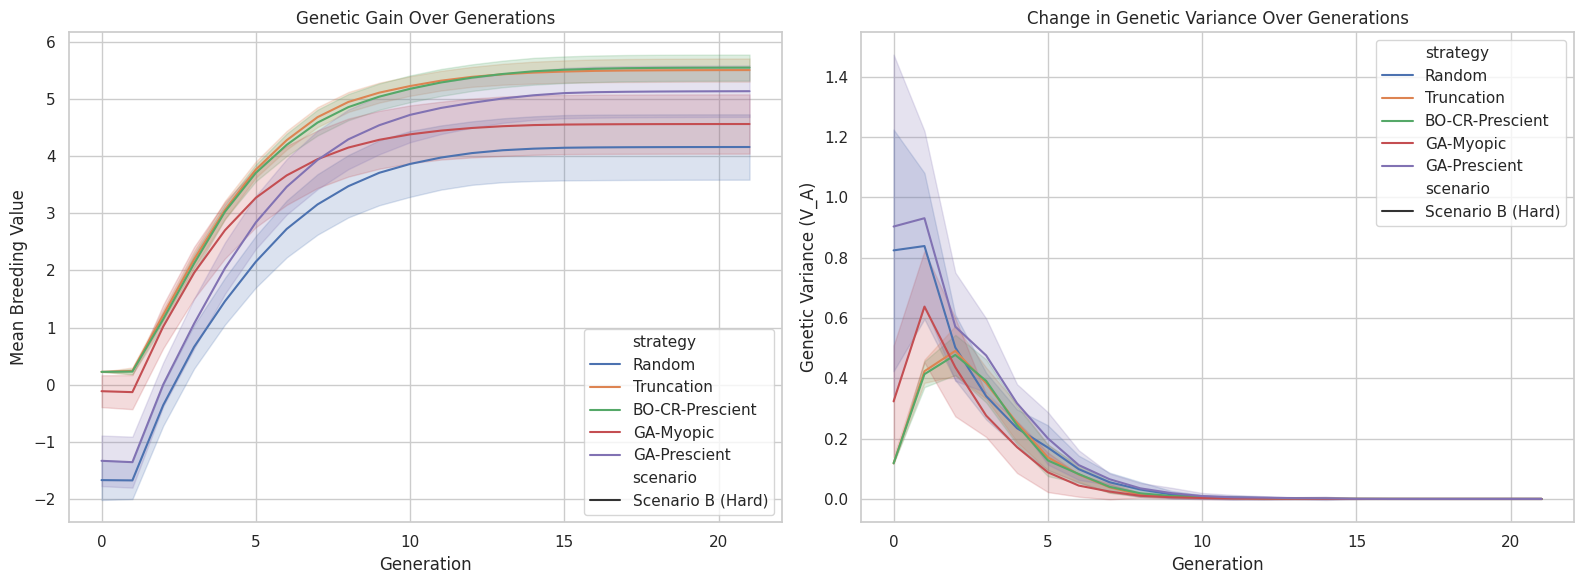

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Genetic Gain (Mean Breeding Value) ---
sns.lineplot(
    data=df_results,
    x="generation",
    y="mean_bv",
    hue="strategy",
    style="scenario",
    ax=axes[0],
    errorbar="sd",
)
axes[0].set_title("Genetic Gain Over Generations")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("Mean Breeding Value")
axes[0].grid(True)

# --- Plot 2: Genetic Variance ---
sns.lineplot(
    data=df_results,
    x="generation",
    y="var_bv",
    hue="strategy",
    style="scenario",
    ax=axes[1],
    errorbar="sd",
)
axes[1].set_title("Change in Genetic Variance Over Generations")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Genetic Variance (V_A)")
axes[1].grid(True)

# Display the plots
plt.tight_layout()
plt.show()


Generating Trajectory Plots...


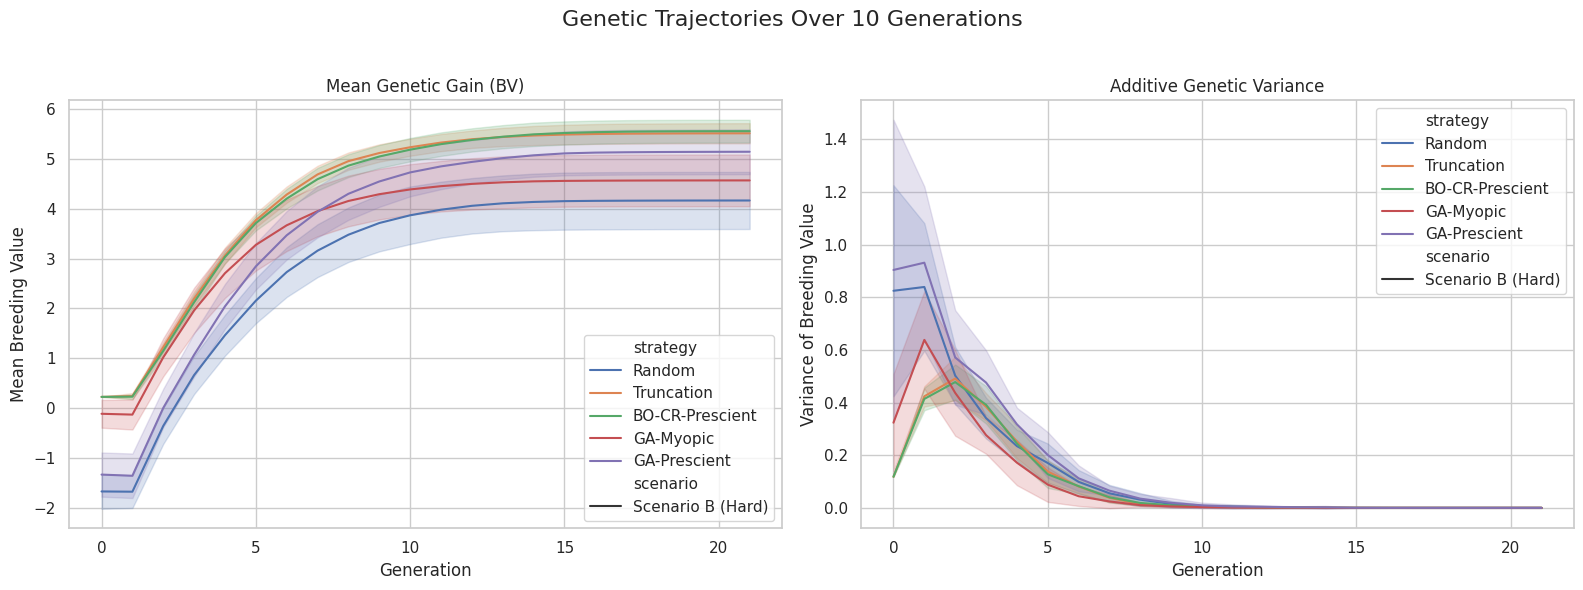


Generating Pareto Plot of Terminal Outcomes...


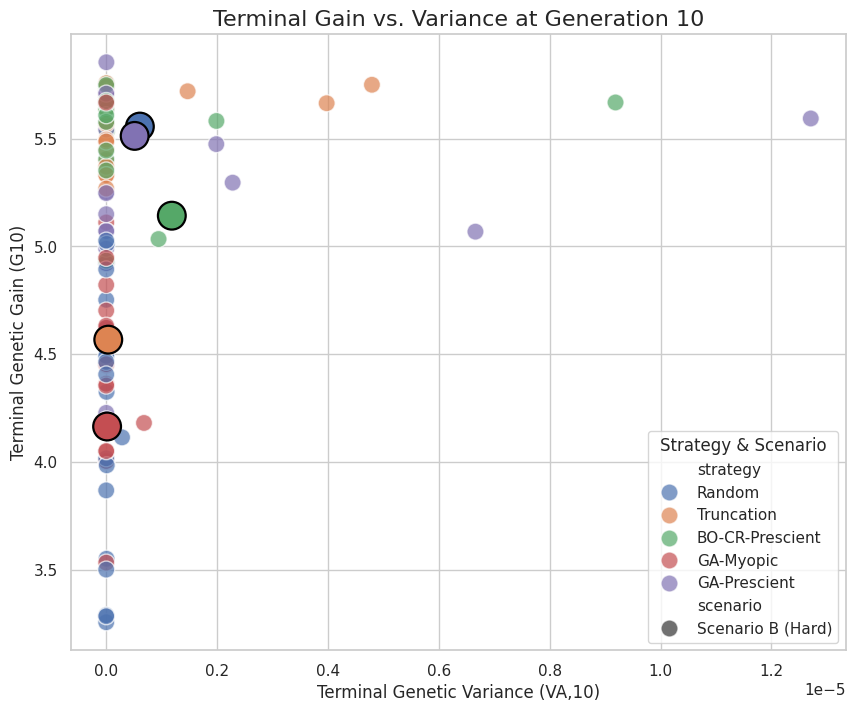


--- Performing ANOVA on Terminal Genetic Gain ---


ValueError: must have at least one row in constraint matrix

In [13]:
# Set plot style
sns.set_theme(style="whitegrid")

# 4b. The "Why": Trajectory Plots
print("\nGenerating Trajectory Plots...")
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)
fig.suptitle('Genetic Trajectories Over 10 Generations', fontsize=16)

# Plot 1: Genetic Gain
sns.lineplot(data=df_results, x='generation', y='mean_bv', hue='strategy', style='scenario', ax=axes[0], errorbar='sd')
axes[0].set_title('Mean Genetic Gain (BV)')
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Mean Breeding Value')

# Plot 2: Genetic Variance
sns.lineplot(data=df_results, x='generation', y='var_bv', hue='strategy', style='scenario', ax=axes[1], errorbar='sd')
axes[1].set_title('Additive Genetic Variance')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Variance of Breeding Value')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# 4a. The Money Shot: The Pareto Plot
print("\nGenerating Pareto Plot of Terminal Outcomes...")
df_terminal = df_results[df_results['generation'] == N_GENERATIONS]

plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_terminal, x='var_bv', y='mean_bv', hue='strategy', style='scenario', s=150, alpha=0.7)

# Calculate and plot centroids
df_centroids = df_terminal.groupby(['scenario', 'strategy']).agg(
    mean_terminal_gain=('mean_bv', 'mean'),
    mean_terminal_var=('var_bv', 'mean')
).reset_index()

sns.scatterplot(data=df_centroids, x='mean_terminal_var', y='mean_terminal_gain', hue='strategy', style='scenario', s=400, edgecolor='black', legend=False)

plt.title('Terminal Gain vs. Variance at Generation 10', fontsize=16)
plt.xlabel('Terminal Genetic Variance (VA,10)')
plt.ylabel('Terminal Genetic Gain (G10)')
plt.legend(title='Strategy & Scenario')
plt.grid(True)
plt.show()


# 4c. The Proof: The ANOVA Table
print("\n--- Performing ANOVA on Terminal Genetic Gain ---")
model = ols('mean_bv ~ C(scenario) * C(strategy)', data=df_terminal).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)